# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


# Load template and create stage

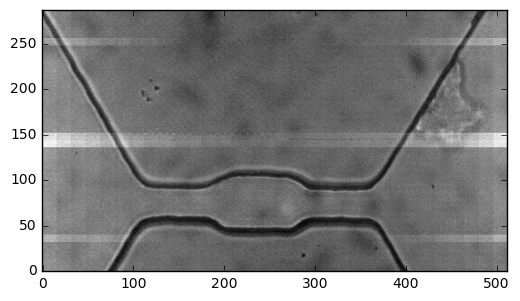

In [4]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

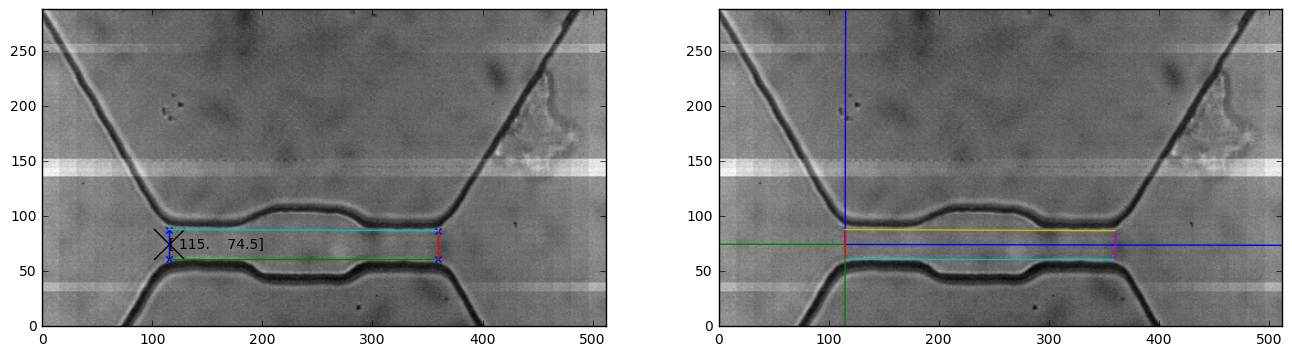

In [9]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [115,88]
c1 = [115,61]
c2 = [360,61]
c3 = [360,87]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Filter out bad events

In [10]:
filtering_steps = []

### Manual filtering

In [11]:
remove_indices = []

filtering_steps.append(['manual removal (num events manually removed)', len(remove_indices)])

oi_events = [oi_events[i] for i in range(len(oi_events)) if i not in remove_indices]



### Size-based filtering

In [12]:
preprocessing_steps = []
def preprocess_frame(raw_frame, template_frame, detection, debug = False):

    # Refresh list
    del preprocessing_steps[:]

    
    
    
    #################################
    # Crop raw frame
    #################################


    x0 = int(detection._px - 30)
    x1 = int(detection._px + 30)
    y0 = int(detection._py - 30)
    y1 = int(detection._py + 30)
    frame = raw_frame[y0:y1, x0:x1]

    
    
    
    
    #################################
    # Copy
    #################################




    preprocessing_steps.append(['copy'])

    processed_frame = 1.*frame

    if debug:
        print 'copy'
        plot_all(processed_frame, frame)


    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(frame - template_frame[y0:y1, x0:x1])


    if debug:
        print 'negative'
        plot_all(processed_frame, frame)




    #################################
    # Blur
    #################################


    blur_kernel = (3,3)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)



    if debug:
        print 'gaussian blur'
        plot_all(processed_frame, frame)





    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug:
        print 'rescale'
        plot_all(processed_frame, frame)






    #################################
    # Threshold
    #################################

    threshold = .15
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0




    if debug:
        print 'threshold'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug:
        print 'erode subtraction'
        plot_all(processed_frame, frame)




    #################################
    # Fill holes
    #################################
    preprocessing_steps.append(['fill holes'])

    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)




    if debug:
        print 'fill holes'
        plot_all(processed_frame, frame)

    #################################    
    # Get largest cluster
    #################################

    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug:
        print 'cluster'
        plot_all(processed_frame, frame)


    #################################
    # Morphological closing
    #################################

    morph_kernel_size = (10,10)
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug:
        print 'morphological closing'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################

    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug:
        print 'erode subtraction'
        plot_all(processed_frame, frame)



    #################################
    # Fit ellipse
    #################################



    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
    
    
    if debug:
        ellipse_center = oi.get_ellipse_center(ellipse)
        ellipse_angle = oi.get_ellipse_angle_of_rotation(ellipse)
        ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)





        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes[0]*np.cos(angle)
            y = ellipse_axes[1]*np.sin(angle)
            ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
            ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame



        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

        plt.xlim(0, frame.shape[1])
        plt.ylim(0, frame.shape[0])

        plt.show()
        
    return ellipse


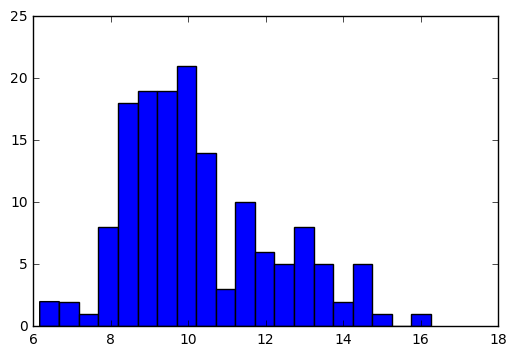

In [16]:
effective_radii = []

for i, oi_event in enumerate(oi_events):
    
    try:


        xs = oi_event.get_px()
        ys = oi_event.get_py()

        xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
        xcs = oi_stage.pixels_to_meters(xcs)

        index = np.where((xcs > -20) & (xcs < 0))[0][0]

        detection = oi_event._detections[index]

        frame = oi_vid.get_frame(detection._tf)

        ellipse = preprocess_frame(frame, template_frame, detection, debug = False)



        ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)

        ellipse_axes[0] = oi_stage.pixels_to_meters(ellipse_axes[0])
        ellipse_axes[1] = oi_stage.pixels_to_meters(ellipse_axes[1])

        effective_radii.append(np.sqrt(ellipse_axes[0]*ellipse_axes[1]))
        
    except:
        print 'failed on ', i

    
plt.hist(effective_radii, bins = 20)
plt.show()

In [17]:
radius_threshold = 11

filtering_steps.append(['effective radius threshold', radius_threshold])

filter_indices = np.where(np.array(effective_radii) > radius_threshold)[0]

print filter_indices

[  4   5  11  13  17  19  22  23  25  32  33  36  37  40  41  43  45  50
  51  59  62  64  65  69  70  72  78  86  87  88  90  94  95 118 124 133
 136 137 141 142 143 144 145 149]


In [18]:
oi_index = 4
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

In [20]:
print 'length before', len(oi_events), 'length after', len(oi_events) - len(filter_indices)
oi_events = [oi_events[i] for i in range(len(oi_events)) if i not in filter_indices]

length before 150 length after 106


# Calculate average velocity

In [19]:
oi_index = 43
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

In [37]:
velocities = []

for i, oi_event in enumerate(oi_events):
    
    try:
    
        oi_event.get_channel_enter_exit_tf(oi_stage)
    
        dx = oi_stage._length_microns*10**(-6.)
        dt = (oi_event._channel_exit_tf - oi_event._channel_enter_tf)*(1/100000.)
        v = dx/dt
    
        velocities.append(v)
    
    except:
        print 'failed on ', i

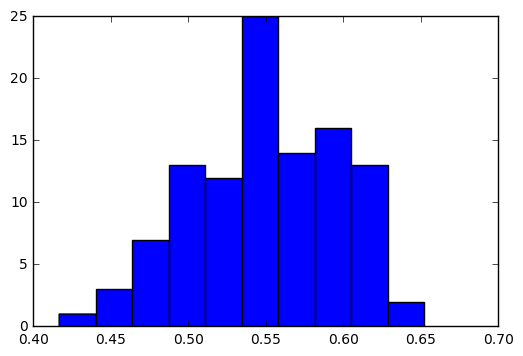

In [38]:
plt.hist(velocities)
plt.show()

In [30]:
print(0.01*0.001*10**-3./(60*20*22*10**(-12.)))

0.378787878788
